Post-suite2P data preprocessing for communication subspace analysis

To use the Semedo et al. code for reduced rank regression etc., the output should be an nxm matrix, where n=number of cells and m = (n trials x n samples in trial bin). If you save this as a .npy, it can be imported to MATLAB using the readNPY.m function found in [npy-matlab](https://github.com/kwikteam/npy-matlab) package.

0.7 neuropil subtraction applied: this can be changed in utils_funcs.s2p_loader

In [1]:
#ipython magic
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
# general imports
import sys
sys.path.append('/home/thijs/Google Drive/repos/Vape/utils')
sys.path.append('/home/thijs/Google Drive/repos/Vape/jupyter/subspace')
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import utils_funcs as utils
from paq2py import paq_read
import sfuncs
import pickle
import h5py

In [16]:
s2p_path = '/run/user/1000/gvfs/smb-share:server=qnap-amp001.dpag.ox.ac.uk,share=sarmstrong/'\
           'Data/2019-07-24/2019-07-24_RL042_t-003/suite2p' 
paq_path = '/run/user/1000/gvfs/smb-share:server=qnap-amp001.dpag.ox.ac.uk,share=sarmstrong/'\
           'Data/2019-07-24/2019-07-24_RL042_B2_2P_t003.paq'

experiment_name = '2019-07-24_RL042_B2_2P_t003'  # for saving purposes
# #if there's an error here, make sure you're connected to PackerStation
plane = 1
tot_planes = 2 # how many planes did you record in total?
load_method = 'suite2p'  # 'suite2p' or 'numpy array'


In [4]:

## To load the stat and paq files, the np.load() functions needs to be altered:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

if load_method == 'suite2p':
    """Use this method to load directly from the suite2p folder"""
    raw, spks, stat = utils.s2p_loader(os.path.join(s2p_path, 'plane{}'.format(plane)))
    dff = utils.dfof2(raw) #compute dF/F
    paq = paq_read(paq_path)
    # restore np.load for future normal usage
    np.load = np_load_old

    ## Get frame_period
    folder_path = s2p_path[:-7]  # move down suite2p folder
    tmp_exp_name= folder_path.split('/')[-2]  # skip last /
    xml_fn = tmp_exp_name + '_BACKUP.xml' # text file containig info
    with open(folder_path + xml_fn) as f:
        for x in range(100): # loop through first 100 lines (should be in there)
            fl = next(f) # iterate line by line
            if 'framePeriod' in fl:  # this is the line with framePeriod info
                fp = fl.split('value=')[1] # get str right side of value=
                fp = fp.lstrip('"')
                fp = fp.rstrip('" />\n')
                frame_period = float(fp)  # automatic check: will throw an error if fp cannot be converted to float
                print(f'frame period found: {frame_period}')
                break  # assume first hit is representative of entire experiment
    
elif load_method == 'numpy array':
    """Use this method to load a pre-made numpy array"""
    cwd = os.getcwd()
    os.chdir('/home/thijs/Google Drive/oxford/packerlab/data_sarah')  # move to data folder

    raw = np.load('raw.npy')
    spks = np.load('spks.npy')
    dff = utils.dfof2(raw) #compute dF/F
    
    # call load_data with allow_pickle implicitly set to true
    stat = np.load('stat.npy')  # stat is a np array (of len n_neurons), each el is a dict
    paq = np.load('paq.npy')
    paq = paq.item()  # unpack to dictionary
    # restore np.load for future normal usage
    np.load = np_load_old

    os.chdir(cwd)
    frame_period = 0.043478004
    print(f'Frame period manually set at {frame_period}')

    
fs = 1 / frame_period # total frame rate Hz (1/frame period from xml file accompanying your recording. This will change when using custom ROIs)
fs = fs / tot_planes #total frame rate is divided by number of planes
print('plane recorded at {0:.4f} frames per second'.format(fs))


Loading 806 traces labelled as cells
Subtracting neuropil with a coefficient of 0.7
frame period found: 0.042914668
plane recorded at 11.6510 frames per second


## Split cells into S1 and S2

In [6]:
# In suite2p, find the cell that is furthest to the right in area S1 and note its index. 
separation_cell_index = 438  # 438 for 2019-07-24_RL042_B2_2P_t003; 19 for 2019-07-24_RL042_B2_2P_t002
# We will split the cells by a linear plane through the cell's X-coordinate
c = sfuncs.getKeyFromStat_1plane(stat,'med',conditional=('original_index',separation_cell_index)) 
print('X coordinate at S1S2 boundary = {}'.format(c[0][1]))

#split cells by boundary coordinate
boundary = c[0][1]
S1_indices, S2_indices = sfuncs.separateByX(stat, boundary) #split all cells in stat based on X coordinate
print('number S1 cells =',len(S1_indices),'; number S2 cells =',len(S2_indices))

#check the split has been performed correctly
assert (len(S2_indices) + len (S1_indices) == stat.shape[0]) # should be True

#check there are no cells in the same group (output should be empty)
assert len(set(S1_indices) & set(S2_indices) ) == 0

Retrieving values for med key where condition met: original_index == 438
X coordinate at S1S2 boundary = 455.0
number S1 cells = 449 ; number S2 cells = 357


In [7]:
# Use indices to split data by region
S1_stat = stat[S1_indices]
S2_stat = stat[S2_indices]
#get deconvolved spikes and dF/F for each area
S1_spks = spks[S1_indices, :]
S2_spks = spks[S2_indices, :]
S1_dff = dff[S1_indices, :]
S2_dff = dff[S2_indices, :]
assert S1_dff.shape[1] == S2_dff.shape[1]
print(f'Number of neurons in S1: {S1_dff.shape[0]}, and S2: {S2_dff.shape[0]}. Number of time points {S1_dff.shape[1]}')

Number of neurons in S1: 449, and S2: 357. Number of time points 12881


## Split data by trial

In [8]:
tot_frames = dff.shape[1] * tot_planes

stim_start = utils.paq_data(paq, 'piezo_stim', threshold_ttl = True)

frame_clock = utils.paq_data(paq, 'frame_clock', threshold_ttl = True)
frame_clock = frame_clock[:tot_frames] # get rid of foxy bonus frames
frame_clock = frame_clock[plane::tot_planes] # just take clocks from the frame you care about

In [10]:
# set the time window for each trial bin here. The authors of the Semedo paper take 1 second of data 
# per trial. As our stim is longer i'll try taking 2 seconds post-stimulus onset. 
# Worth playing with this

pre_seconds = 0
post_seconds = 2
pre_frames = int(pre_seconds * fs) # number of frames before stim onset to inlcude in the trial
post_frames = int(post_seconds * fs) # number of frames after stim onset to inlcude in the trial

offset_s = 0 # option to offset trial bins from stimulus onset
second_in_samples = 22000
offset_frames = int(offset_s * second_in_samples)

In [11]:
#spikes S1
spks_trials_S1 = utils.flu_splitter(S1_spks, frame_clock, stim_start, pre_frames, post_frames)
spks_trials_S1 = spks_trials_S1[0]
print(f'Shape spikes trial-based S1 {spks_trials_S1.shape}')

#spikes S2
spks_trials_S2 = utils.flu_splitter(S2_spks, frame_clock, stim_start, pre_frames, post_frames)
spks_trials_S2 = spks_trials_S2[0]
print(f'Shape spikes trial-based S2 {spks_trials_S2.shape}')

#dFF S1
dff_trials_S1 = utils.flu_splitter(S1_dff, frame_clock, stim_start+offset_frames, pre_frames, post_frames)
dff_trials_S1 = dff_trials_S1[0]
assert dff_trials_S1.shape == spks_trials_S1.shape

#dFF S2
dff_trials_S2 = utils.flu_splitter(S2_dff, frame_clock, stim_start+offset_frames, pre_frames, post_frames)
dff_trials_S2 = dff_trials_S2[0]
assert dff_trials_S2.shape == spks_trials_S2.shape

Shape spikes trial-based S1 (449, 23, 100)
Shape spikes trial-based S2 (357, 23, 100)


## Subtract mean and reshape back to 2D


In [12]:
def zero_mean(data):
    """Assume 3D, last dimension is trials"""
    assert len(data.shape) == 3
    mean_data_reshaped = np.mean(data, 2)[:, :, np.newaxis]  # mean over trials
    data_subbed = data - mean_data_reshaped  # zero mean data
    assert data_subbed.shape == data.shape
    data_subbed_rs = np.reshape(a=data_subbed, 
                                newshape=(data_subbed.shape[0], 
                                          data_subbed.shape[1] * data_subbed.shape[2]),
                                order='F')  # reshape, take into account right order
    return data_subbed_rs, np.squeeze(mean_data_reshaped)

## TMP

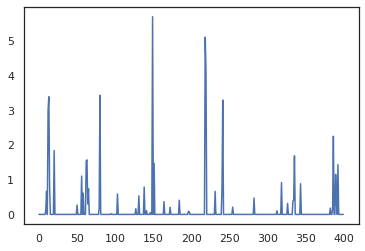

In [10]:
# plt.plot(dff_trials_S1.reshape(185, 2300, order='F')[38, 300:700])
plt.plot(spks_trials_S1.reshape(185, 2300, order='F')[38, 300:700] / 35);

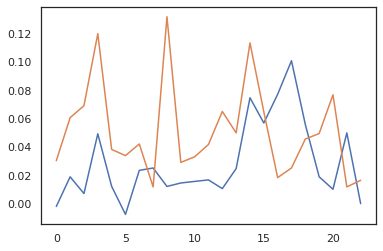

In [11]:
plt.plot(dff_trials_S1.mean(2)[23, :])
plt.plot(spks_trials_S1.mean(2)[23, :] / 35)

(1200, 1600)

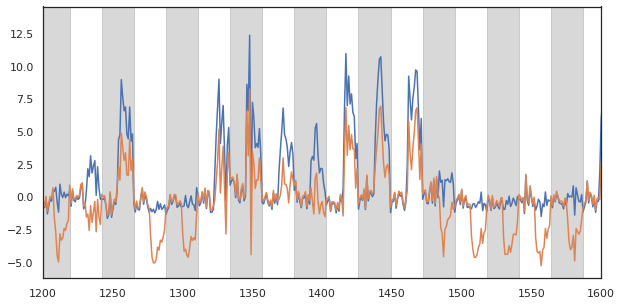

In [33]:
plot_n = 9 # np.argmax(zm_data['sarah']['dff_s2_mean'].sum(1))
plt.rcParams['figure.figsize'] = (10, 5)

plt.plot(dff_trials_S2[plot_n, :, :].reshape(-1, order='F'))

plt.plot(zero_mean(dff_trials_S2)[0][plot_n, :])
for i_trial in range(50):
    plt.axvspan(i_trial * 46, (i_trial + 0.5) * 46, color='grey', alpha=0.3)
# for 
plt.xlim([1200, 1600])

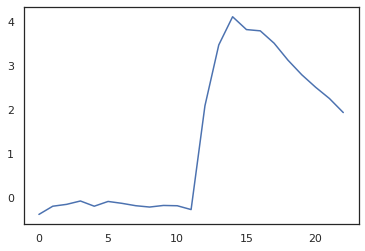

In [29]:
plt.plot(dff_trials_S2[9, :, :].mean(1))

## Export data to use

In [13]:
## Define empty dict
dict_export = {}


In [14]:
## Fill dict with the zero-meaned data
dict_export['dff_s1'], dict_export['dff_s1_mean'] = zero_mean(dff_trials_S1)
dict_export['dff_s2'], dict_export['dff_s2_mean'] = zero_mean(dff_trials_S2)
dict_export['spikes_s1'], dict_export['spikes_s1_mean'] = zero_mean(spks_trials_S1)
dict_export['spikes_s2'], dict_export['spikes_s2_mean'] = zero_mean(spks_trials_S2)



In [21]:
## Save as h5 file so it can be read in matlab/pyton
print(f'Current directory: {os.getcwd()}')
hfile = h5py.File(f'data_sarah_s1s2_zero_mean_{experiment_name}.h5', 'w') # create file
for key, val in dict_export.items():  # store data
    hfile.create_dataset(key, data=val)
hfile.create_dataset('name_experiment', data=experiment_name)
hfile.close()  # close file

Current directory: /home/thijs/Google Drive/oxford/packerlab/code


In [25]:
## To load:

# hfile = h5py.File(f'data_sarah_s1s2_zero_mean_{experiment_name}.h5', 'r')  # open with read access
# data = hfile['dff_s1']  # memory-mapped access (until hfile is closed)
# data = hfile['dff_s1'].value  # RAM access (permanent)
# # hfile.close()